An implementation of sequence to sequence learning for performing the following op
Input: "535+61"
Output: "596"

In [1]:
#Importing everything that is needed
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Will use only 2nd, 3rd and 4th gpu

from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import random

Using TensorFlow backend.


In [2]:
#Parameters
TRAIN_DATA = 5000
TEST_DATA = int(TRAIN_DATA * 0.5)

chars = '0123456789 abcdefghijklmnopqrstuvwxyz'

#NN parameters
RNN = layers.LSTM
HIDDEN_SIZE = 256
BATCH_SIZE = 128
LAYERS = 3
ITERATIONS = 200

MAX_LEN_X = 6
MAX_LEN_Y = int( (6 / 3) * (99 + 1) )

class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
class CharacterTable():
    """
    Given a set of chars:
    - encode them to one hot integer representations
    - decode the one hot integer representations to their original chars
    - decode a vector of pr
    """
    def __init__(self, chars):
        """
        Initialise character table
        """
        self.chars = sorted(set(chars))
        self.char_to_nr = dict( (ch, nr) for nr, ch in enumerate(self.chars) )
        self.nr_to_char = dict( (nr, ch) for nr, ch in enumerate(self.chars) )
        
    def encode(self, str, num_rows):
        """
        One hot encodes str
        params: num_rows for keeping the num_rows the same
        """
        
        #Matrice of zeros with the following shape [number_of_lines][total_chars_per_line]
        x = np.zeros((num_rows, len(self.chars)))
        
        #Do the encoding
        for i, ch in enumerate(str):
            x[i, self.char_to_nr[ch]] = True
        
        return x
        
    def decode(self, x, calc_argmax = True):
        """
        Decodes x and returns it
        """
        if calc_argmax:
            x = x.argmax(axis = -1)
        
        return ''.join(self.nr_to_char[x] for x in x)

In [4]:
#Generator for the data
class GenerateData():
    """
    Generate train & test data for the NN
    """
    
    def __init__(self, n_train, n_test, max_len):
        chars = 'abcdefghijklmnopqrstuvwxyz'
        self.char_to_nr = dict( (ch, nr) for nr, ch in enumerate(chars) )
        self.nr_to_char = dict( (nr, ch) for nr, ch in enumerate(chars) )
        self.n_train = n_train
        self.n_test = n_test
        self.max_len = max_len
        
    def generateAll(self):
        x1, y1 = self.generate(self.n_train, self.max_len)
        x2, y2 = self.generate(self.n_test, self.max_len)
        return x1, y1, x2, y2
    
    def generate(self, n, max_len):
        """
        Generate n data of the form x,y (with max max_len length per data)
        """
        x = []
        y = []
        for i in range(n):
            crt_x = ''
            crt_y = ''
            
            for j in range(max_len[0] / 3):
                crt_nr = random.randint(1, 99)
                crt_ch = self.nr_to_char[random.randint(0, 25)]
                
                crt_x += str(crt_nr) + crt_ch
                for h in range(crt_nr):
                    crt_y += crt_ch
                
            while len(crt_y) < max_len[1]:
                 crt_y += ' '
                
            x.append(crt_x)
            y.append(crt_y)
        
        return x, y

In [5]:
#Generate & Vectorise data
generator = GenerateData(TRAIN_DATA, TEST_DATA, (MAX_LEN_X, MAX_LEN_Y))
encoder = CharacterTable(chars)

x_train_aux, y_train_aux, x_test_aux, y_test_aux = generator.generateAll()

x_train = np.zeros( (TRAIN_DATA, MAX_LEN_X, len(chars)), dtype = np.bool )
x_test = np.zeros( (TEST_DATA, MAX_LEN_X, len(chars)), dtype = np.bool )
y_train = np.zeros( (TRAIN_DATA, MAX_LEN_Y, len(chars)), dtype = np.bool )
y_test = np.zeros( (TEST_DATA, MAX_LEN_Y, len(chars)), dtype = np.bool )

for i, line in enumerate(x_train_aux):
    x_train[i] = encoder.encode(line, MAX_LEN_X)

for i, line in enumerate(x_test_aux):
    x_test[i] = encoder.encode(line, MAX_LEN_X) 
    
for i, line in enumerate(y_train_aux):
    y_train[i] = encoder.encode(line, MAX_LEN_Y)

for i, line in enumerate(y_test_aux):
    y_test[i] = encoder.encode(line, MAX_LEN_Y)

In [6]:
print("Training data: ", x_train.shape, ", ", y_train.shape)
print("Testing data: ", x_test.shape, ", ", y_test.shape)

Training data:  (5000, 6, 37) ,  (5000, 200, 37)
Testing data:  (2500, 6, 37) ,  (2500, 200, 37)


In [ ]:
#Build the model

model = Sequential()

model.add(RNN(
    HIDDEN_SIZE,
    input_shape= ( MAX_LEN_X, len(chars) ) #input shape = (SIZE_OF_LINE_X, NUMBER_OF_DISTINCT_CHARS)
    )
)
model.add(layers.RepeatVector(MAX_LEN_Y))

for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
  
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 256)           301056      lstm_input_1[0][0]               
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 200, 256)      0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 200, 256)      525312      repeatvector_1[0][0]             
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 200, 256)      525312      lstm_2[0][0]                     
___________________________________________________________________________________________

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:368: UserWarning: The `regularizers` property of layers/models is deprecated. Regularization losses are now managed via the `losses` layer/model property.
  warnings.warn('The `regularizers` property of '


In [ ]:
#Train the model

for iteration in range(ITERATIONS):
    print()
    print("Iteration: ", iteration)
    
    model.fit(x_train, y_train,
             batch_size = BATCH_SIZE,
             nb_epoch = 1,
             validation_data = (x_test, y_test))
    
    #Select 10 samples from the validation data
    for i in range(10):
        ind = np.random.randint(0, len(x_test))
        rowx, rowy = x_test[np.array([ind])], y_test[np.array([ind])]
        
        preds = model.predict_classes(rowx, verbose = 0)
        q = encoder.decode(rowx[0])
        correct = encoder.decode(rowy[0])
        guess = encoder.decode(preds[0], calc_argmax = False)
        
        print('Q', q)
        print('T', correct)
        if correct == guess:
            print(colors.ok + 'K' + colors.close, end=" ")
        else:
            print(colors.fail + 'N' + colors.close, end=" ")
        print(guess)


Iteration:  0
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 44s - loss: 2.2482 - acc: 0.4905 - val_loss: 1.9789 - val_acc: 0.5053
Q 78e75g
T eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg                                               
N   ccccccccccnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnfffffff                                                                                                                                              
Q 35v79i
T vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvviiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                                                      
N    cccccccnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnffffff                                                                                                                                         

Q 73x56i
T xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                                       
N   ccccnnnneeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee                                                                                                                                          

Iteration:  2
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 44s - loss: 1.8430 - acc: 0.5181 - val_loss: 1.8101 - val_acc: 0.5310
Q 75d96t
T dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddtttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt                             
N   cddddddddttttttttttttttttttttttttttttttttttttttttttttttttttttttttdddddddddddddddlllllllllll                                                                                          

Q 9r29x 
T rrrrrrrrrxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                                                                                  
N n  ccccccccxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                                                          
Q 21j9s 
T jjjjjjjjjjjjjjjjjjjjjsssssssss                                                                                                                                                                          
N n ssttttddddddddddddddddddddddddddddddddtttt                                                                                                                                                            

Iteration:  4
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 1.5766 - acc: 0.5612 - val_loss: 1.5509 

Q 32i71v
T iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiivvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                                                                 
N piiiaaaaaaaavooooooooogggggggggggggggggggmmmmmmmmmmmmmmmmmmmmmmmmmmmmggggggggggggggg                                                                                                                    
Q 24d74y
T ddddddddddddddddddddddddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                                      
N uyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                                         

Iteration:  6
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 1.3166 - acc: 0.6164 - val_loss: 1.2918 

Q 36r69f
T rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrfffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff                                                                                               
N aeggggggggggggggggggggggggggggggggggggffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff                                                                                                      
Q 29p78h
T ppppppppppppppppppppppppppppphhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                             
N iiippppppppppppppppjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjhhwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww                                                                                    
Q 46t90r
T ttttttttttttttttttttttttttttttttttttttttttttttrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr                       

Q 66h67i
T hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                                   
N hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiaaaaaaaaaaaaiilllll                                                                               
Q 33q96y
T qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                       
N qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                             
Q 47v62w
T vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww                                                  

Q 70a1n 
T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaan                                                                                                                                 
N aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaann                                                                                                                                   
Q 28w47v
T wwwwwwwwwwwwwwwwwwwwwwwwwwwwvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                                                                                             
K wwwwwwwwwwwwwwwwwwwwwwwwwwwwvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                                                                                             
Q 57y38d
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyydddddddddddddddddddddddddddddddddddddd                                                                

Q 12p74u
T ppppppppppppuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                                                                                                                  
K ppppppppppppuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                                                                                                                  
Q 79x53d
T xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxddddddddddddddddddddddddddddddddddddddddddddddddddddd                                                                    
N xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxddddddddddddddddddddddddddddddddddddddddddddddddddddddd                                                              
Q 64r53x
T rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                          

Q 11h53c
T hhhhhhhhhhhccccccccccccccccccccccccccccccccccccccccccccccccccccc                                                                                                                                        
N ccchhhccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc                                                                                                                                       
Q 5y58i 
T yyyyyiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                                                                                                         
N uuuuuuuuuuuuuuutttttttiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                                                                                    
Q 51e41k
T eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeekkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                                                   

T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                
N aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                        
Q 45f84x
T fffffffffffffffffffffffffffffffffffffffffffffxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                       
N ffffffffffffffffffffffffffffffffffffffffffffxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                           
Q 86s41i
T ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                         

Q 64j99u
T jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                                     
N jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                       
Q 44z75j
T zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                                 
N zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                     
Q 91n64v
T nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv    

Q 58l88n
T llllllllllllllllllllllllllllllllllllllllllllllllllllllllllnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn                                                      
N lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn                                                
Q 50i77f
T iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiifffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff                                                                         
N iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiifffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff                                                                           
Q 78y48a
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                 

5000/5000 [==============================] - 43s - loss: 0.1043 - acc: 0.9719 - val_loss: 0.1577 - val_acc: 0.9565
Q 70e55d
T eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeddddddddddddddddddddddddddddddddddddddddddddddddddddddd                                                                           
N eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddddddddddddddddddddddddddddddddddddddddd                                                                               
Q 59s7f 
T sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfffffff                                                                                                                                      
N ssssssyyyyyyyyyyysssssssssssssssssssssssssssssssssssfffffffffffff                                                                                                                                       
Q 20o55w
T oooooooooooooooooooowwwwwwwwwwwwwwwwwwwwwwww

5000/5000 [==============================] - 44s - loss: 0.0790 - acc: 0.9794 - val_loss: 0.1041 - val_acc: 0.9714
Q 76r78n
T rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn                                              
N rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn                                                    
Q 85g14d
T gggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggdddddddddddddd                                                                                                     
N gggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggddddddddddddddddddd                                                                                                    
Q 33p63x
T pppppppppppppppppppppppppppppppppxxxxxxxxxxx

Q 40t26u
T ttttttttttttttttttttttttttttttttttttttttuuuuuuuuuuuuuuuuuuuuuuuuuu                                                                                                                                      
N tttttttttttttttttttttttttttttttttttttttttuuuuuuuuuuuuuuuuuuuuuuu                                                                                                                                        

Iteration:  27
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0751 - acc: 0.9798 - val_loss: 0.1633 - val_acc: 0.9528
Q 27v81j
T vvvvvvvvvvvvvvvvvvvvvvvvvvvjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                                            
N vvvvvvvvvvvvvvvvvvvvvvvvvvjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                       

Q 83z7z 
T zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                                              
N zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                                       

Iteration:  29
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0684 - acc: 0.9813 - val_loss: 0.0724 - val_acc: 0.9808
Q 59v54n
T vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn                                                                                       
N vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn                                                                    

Q 43k33s
T kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkksssssssssssssssssssssssssssssssss                                                                                                                            
N kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkksssssssssssssssssssssssssssssssssss                                                                                                                             
Q 77o18i
T oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooiiiiiiiiiiiiiiiiii                                                                                                         
N oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooiiiiiiiiiiiiiiiiii                                                                                                               

Iteration:  31
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 44s - loss: 0.0739 - acc: 0.9791 - val_loss: 0.0963

Q 20f2t 
T fffffffffffffffffffftt                                                                                                                                                                                  
N fffffffffffffffffftt                                                                                                                                                                                    
Q 66g88b
T ggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                              
N gggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                                 

Iteration:  33
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 42s - loss: 0.0625 - acc: 0.9821 - val_loss: 0.0653

Q 81u96y
T uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                       
N uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                              
Q 24z78a
T zzzzzzzzzzzzzzzzzzzzzzzzaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                                  
N zzzzzzzzzzzzzzzzzzzzzzzzaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                                        

Iteration:  35
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 44s - loss: 0.0540 - acc: 0.9852 - val_loss: 0.0592

Q 87i87x
T iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiixxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                          
N iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiinnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn             
Q 49j91l
T jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjlllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll                                                            
N jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll                                                   

Iteration:  37
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.2334 - acc: 0.9327 - val_loss: 0.1550

Q 94u15s
T uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuusssssssssssssss                                                                                           
N uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuusssssssssssssssss                                                                                       
Q 35x34o
T xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxoooooooooooooooooooooooooooooooooo                                                                                                                                   
N xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxoooooooooooooooooooooooooooooooooooo                                                                                                                                 
Q 49j91l
T jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjlllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll                   

Q 56p29a
T ppppppppppppppppppppppppppppppppppppppppppppppppppppppppaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                                                   
N pppppppppppppppppppppppppppppppppppppppppppppppppppppppppaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                                                    
Q 67t88q
T tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                             
N tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                 
Q 26k20v
T kkkkkkkkkkkkkkkkkkkkkkkkkkvvvvvvvvvvvvvvvvvvvv                                                                                                                 

Q 94d97a
T ddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa         
N ddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa         
Q 8k71s 
T kkkkkkkksssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss                                                                                                                         
N ikkkkkkkiissssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss                                                                                                                            
Q 95w49w
T wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww               

T tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttnnnnnnnnnnnnnnnnnnnnnnnnn                                                                                                            
N ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttnnnnnnnnnnnnnnnnnnnnnnnnn                                                                                                           
Q 35g83m
T gggggggggggggggggggggggggggggggggggmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                  
N gggggggggggggggggggggggggggggggggggmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                
Q 10w97q
T wwwwwwwwwwqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                             

Q 22n93a
T nnnnnnnnnnnnnnnnnnnnnnaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                     
N nnnnnnnnnnnnnnnnnnnnnnnaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                   
Q 46z81g
T zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg                                                                         
N zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzgggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg                                                                  
Q 52r7y 
T rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrryyyyyyy                                                                                                    

Q 21u12u
T uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                                                                                                                                                                       
N uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                                                                                                                                                                      
Q 32f42p
T ffffffffffffffffffffffffffffffffpppppppppppppppppppppppppppppppppppppppppp                                                                                                                              
N ffffffffffffffffffffffffffffffffpppppppppppppppppppppppppppppppppppppppppppp                                                                                                                            
Q 10r34q
T rrrrrrrrrrqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                                                                                   

Q 98v60e
T vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvveeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee                                          
N vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvveeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee                                               
Q 80y15i
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyiiiiiiiiiiiiiii                                                                                                         
N yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyiiiiiiiiiiiiii                                                                                                          
Q 90f79b
T ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb

Q 9i43t 
T iiiiiiiiittttttttttttttttttttttttttttttttttttttttttt                                                                                                                                                    
N iiiiiiiiiittttiiiiiitttttttttttiiiiiiiiiiiiiii                                                                                                                                                          
Q 17f47h
T fffffffffffffffffhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                                                        
N fffffffffffffffffffhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                                                   
Q 12i29v
T iiiiiiiiiiiivvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                                                                                      

5000/5000 [==============================] - 43s - loss: 0.0591 - acc: 0.9812 - val_loss: 0.0506 - val_acc: 0.9845
Q 17n1s 
T nnnnnnnnnnnnnnnnns                                                                                                                                                                                      
N nnnnnnnnnnnnnnsss                                                                                                                                                                                       
Q 62e16s
T eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeessssssssssssssss                                                                                                                          
N eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeesssssssssssssssss                                                                                                                        
Q 36w24x
T wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwxxxxxxxx

Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 42s - loss: 0.0406 - acc: 0.9879 - val_loss: 0.0510 - val_acc: 0.9835
Q 16z2c 
T zzzzzzzzzzzzzzzzcc                                                                                                                                                                                      
N zzzzzzzzzzzzv                                                                                                                                                                                           
Q 7p54m 
T pppppppmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                                                                           
N ppppppppmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                                                                          

Q 26m11m
T mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                                                                                                   
N mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                                                                                                    

Iteration:  58
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0388 - acc: 0.9877 - val_loss: 0.0355 - val_acc: 0.9894
Q 95f32q
T fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                                         
N fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                         

Q 17l56h
T lllllllllllllllllhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                                               
N llllllllllllllllhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                                                
Q 78j32v
T jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                                                          
N jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                                                          

Iteration:  60
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0305 - acc: 0.9905 - val_loss: 0.0347

Q 20v89g
T vvvvvvvvvvvvvvvvvvvvggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg                                                                                           
N vvvvvvvvvvvvvvvvvvvvgggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg                                                                                              
Q 90g29z
T ggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                 
N gggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                
Q 38o54k
T ooooooooooooooooooooooooooooooooooooookkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                                                   

Q 88y72o
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo                                        
N yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo                                 
Q 48a54k
T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaakkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                                                                                  
N aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaakkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                                                                             
Q 44g70d
T ggggggggggggggggggggggggggggggggggggggggggggdddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd                                             

Q 82j32y
T jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                      
N jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                       
Q 71q8q 
T qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                                                                                         
N qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                                                                                        
Q 39a78e
T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee                                          

Q 51o25k
T oooooooooooooooooooooooooooooooooooooooooooooooooookkkkkkkkkkkkkkkkkkkkkkkkk                                                                                                                            
N oooooooooooooooooooooooooooooooooooooooooooooooooookkkkkkkkkkkkkkkkkkkkkkk                                                                                                                              
Q 15j25z
T jjjjjjjjjjjjjjjzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                                                                                                
N jjjjjjjjjjjjjjjjzzzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                                                                                             
Q 99l75s
T lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

Q 92x59i
T xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                 
N xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                
Q 22d50f
T ddddddddddddddddddddddffffffffffffffffffffffffffffffffffffffffffffffffff                                                                                                                                
N dddddddddddddddddddddffffffffffffffffffffffffffffffffffffffffffffffffffff                                                                                                                               
Q 78b38k
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                           

Q 80y75k
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyykkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                             
K yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyykkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                             
Q 54l26h
T llllllllllllllllllllllllllllllllllllllllllllllllllllllhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                                        
N llllllllllllllllllllllllllllllllllllllllllllllllllllllhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                                       
Q 6h91s 
T hhhhhhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss                                                              

Q 14c3e 
T cccccccccccccceee                                                                                                                                                                                       
N cccccccccccccccccccc                                                                                                                                                                                    
Q 75c34x
T cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                           
N cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                        
Q 46a5i 
T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaiiiii                                                                                                            

T xxxxhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                             
N xxxxhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                          
Q 40t10s
T ttttttttttttttttttttttttttttttttttttttttssssssssss                                                                                                                                                      
N ttttttttttttttttttttttttttttttttttttttttsssssssssss                                                                                                                                                     
Q 81z98m
T zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm

Q 4y36m 
T yyyymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                                                                                                
N yyyyymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                                                                                               
Q 29g20q
T gggggggggggggggggggggggggggggqqqqqqqqqqqqqqqqqqqq                                                                                                                                                       
N ggggggggggggggggggggggggggggqqqqqqqqqqqqqqqqqqqqq                                                                                                                                                       
Q 25h43f
T hhhhhhhhhhhhhhhhhhhhhhhhhfffffffffffffffffffffffffffffffffffffffffff                                                                                           

Q 82u62d
T uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuudddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd                                                        
N uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd                                                          
Q 16y18g
T yyyyyyyyyyyyyyyygggggggggggggggggg                                                                                                                                                                      
N yyyyyyyyyyyyyyygggggggggggggg                                                                                                                                                                           
Q 91b38i
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                              

Q 69j93f
T jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjfffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff                                      
N jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjfffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff                                         
Q 68l68b
T llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                                                
N lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                                                  
Q 96f23u
T ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffuuuuuuuuuuuuuuuuuuuuuuu                                        

5000/5000 [==============================] - 42s - loss: 0.0215 - acc: 0.9919 - val_loss: 0.0289 - val_acc: 0.9886
Q 90f79b
T ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                               
N fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                               
Q 79s24j
T sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssjjjjjjjjjjjjjjjjjjjjjjjj                                                                                                 
N sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssjjjjjjjjjjjjjjjjjjjjjjjjj                                                                                                
Q 54n31p
T nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn

5000/5000 [==============================] - 42s - loss: 0.0292 - acc: 0.9890 - val_loss: 0.0244 - val_acc: 0.9909
Q 47r41x
T rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                                
N rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                                 
Q 70e55d
T eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeddddddddddddddddddddddddddddddddddddddddddddddddddddddd                                                                           
K eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeddddddddddddddddddddddddddddddddddddddddddddddddddddddd                                                                           
Q 51w55q
T wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww

Q 66b94b
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                        
K bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                        

Iteration:  87
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0245 - acc: 0.9902 - val_loss: 0.0258 - val_acc: 0.9897
Q 76b45k
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                                                               
N bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk                                                              

Q 11x38m
T xxxxxxxxxxxmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                                                                                       
N xxxxxxxxxxxxmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                                                                                                       

Iteration:  89
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0224 - acc: 0.9918 - val_loss: 0.0401 - val_acc: 0.9852
Q 49u62g
T uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg                                                                                         
N uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg                                                                         

Q 44e89t
T eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeettttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt                                                                   
N eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeettttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt                                                                          

Iteration:  91
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0927 - acc: 0.9692 - val_loss: 0.0798 - val_acc: 0.9734
Q 66n68c
T nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnncccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc                                                                  
N nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnncccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc                                                       

Q 79h32w
T hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww                                                                                         
N hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww                                                                                    
Q 75f72r
T fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr                                                     
N fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr                                                    

Iteration:  93
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 42s - loss: 0.0334 - acc: 0.9876 - val_loss: 0.0344

T kkkkkkkkkkkkkkkzzzz                                                                                                                                                                                     
N kkkkkkkkkkkkkkzzzzz                                                                                                                                                                                     
Q 7m96h 
T mmmmmmmhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                 
N hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                                                  
Q 81d87d
T dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd

Q 31u59y
T uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                                              
K uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                                              
Q 59n28d
T nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnndddddddddddddddddddddddddddd                                                                                                                 
N nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnddddddddddddddddddddddddddd                                                                                                                   
Q 24d59o
T ddddddddddddddddddddddddooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo                                                                            

Q 49a47z
T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaazzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                                        
N aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaazzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                                                                                                       
Q 35l60i
T llllllllllllllllllllllllllllllllllliiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                                                                         
K llllllllllllllllllllllllllllllllllliiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii                                                                                                         
Q 1p49j 
T pjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                                                             

Q 28i68x
T iiiiiiiiiiiiiiiiiiiiiiiiiiiixxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                        
K iiiiiiiiiiiiiiiiiiiiiiiiiiiixxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                        
Q 26y60u
T yyyyyyyyyyyyyyyyyyyyyyyyyyuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                                                                                                                  
N yyyyyyyyyyyyyyyyyyyyyyyyyuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                                                                                                                 
Q 20x84r
T xxxxxxxxxxxxxxxxxxxxrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr                                                       

T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssss                                                                                                                              
N aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssss                                                                                                                             
Q 72v95h
T vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                 
N vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                     
Q 87i87x
T iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiixxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Q 46q20t
T qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqtttttttttttttttttttt                                                                                                                                      
N qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqtttttttttttttttttttt                                                                                                                                       
Q 8j53b 
T jjjjjjjjbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                                                                                                                           
N jjjjjjjjbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                                                                                                                               
Q 74n49f
T nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnfffffffffffffffffffffffffffffffffffffffffffffffff                                    

Q 35z52t
T zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzztttttttttttttttttttttttttttttttttttttttttttttttttttt                                                                                                                 
N zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzztttttttttttttttttttttttttttttttttttttttttttttttttttt                                                                                                                  
Q 55v58w
T vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww                                                                                       
N vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww                                                                                       
Q 99b64o
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbboooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo

Q 45r6j 
T rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrjjjjjj                                                                                                                                                     
N rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrjjjjjj                                                                                                                                                      
Q 30o81t
T oooooooooooooooooooooooooooooottttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt                                                                                         
K oooooooooooooooooooooooooooooottttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt                                                                                         
Q 66v5l 
T vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvlllll                                                                                        

5000/5000 [==============================] - 43s - loss: 0.0141 - acc: 0.9945 - val_loss: 0.0349 - val_acc: 0.9876
Q 93y38t
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyytttttttttttttttttttttttttttttttttttttt                                                                     
N yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyttttttttttttttttttttttttttttttttttttt                                                                         
Q 29s21o
T sssssssssssssssssssssssssssssooooooooooooooooooooo                                                                                                                                                      
N sssssssssssssssssssssssssssssooooooooooooooooooo                                                                                                                                                        
Q 63y90s
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

N llllllllllllllllllllllllllllllllllllllllllllllxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                     
Q 97f45v
T fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                          
N fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                        

Iteration:  112
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 42s - loss: 0.0131 - acc: 0.9950 - val_loss: 0.0226 - val_acc: 0.9913
Q 28w9g 
T wwwwwwwwwwwwwwwwwwwwwwwwwwwwggggggggg                                                                                                                                                

Q 35i57j
T iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiijjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                                                            
N iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiijjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                                                          
Q 72e45v
T eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeevvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                                                   
N eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeevvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv                                                                                  

Iteration:  117
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0195 - acc: 0.9921 - val_loss: 0.033

Q 35y60x
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                         
K yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                         
Q 90p41m
T ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                     
N ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm                                                                   
Q 61c68u
T cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu                              

Q 35a98h
T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                   
N aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                                                 
Q 28b84e
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee                                                                                        
N bbbbbbbbbbbbbbbbbbbbbbbbbbbbbeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee                                                                                       
Q 29c50g
T cccccccccccccccccccccccccccccgggggggggggggggggggggggggggggggggggggggggggggggggg                                                                                

Q 88q59x
T qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                     
N qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                    
Q 78n6d 
T nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnndddddd                                                                                                                    
K nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnndddddd                                                                                                                    
Q 49b94q
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                

Q 55u97q
T uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                
N uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq                                                 
Q 70i98h
T iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                
N iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh                                
Q 19w69s
T wwwwwwwwwwwwwwwwwwwsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss                                                                       

Q 90x20w
T xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxwwwwwwwwwwwwwwwwwwww                                                                                          
N xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxwwwwwwwwwwwwwwwwwwww                                                                                         
Q 15j23i
T jjjjjjjjjjjjjjjiiiiiiiiiiiiiiiiiiiiiii                                                                                                                                                                  
K jjjjjjjjjjjjjjjiiiiiiiiiiiiiiiiiiiiiii                                                                                                                                                                  
Q 35v54p
T vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvpppppppppppppppppppppppppppppppppppppppppppppppppppppp                                                                      

Q 48z98p
T zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzpppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp                                                      
K zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzpppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp                                                      
Q 60b28c
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbcccccccccccccccccccccccccccc                                                                                                                
N bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbcccccccccccccccccccccccccccc                                                                                                               
Q 4v45n 
T vvvvnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn                                                                                                              

Q 24d74y
T ddddddddddddddddddddddddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                                      
K ddddddddddddddddddddddddyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                                      
Q 43k78e
T kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee                                                                               
K kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee                                                                               
Q 53l78l
T lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll                            

Q 39y63y
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                                  
K yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                                  
Q 18j28x
T jjjjjjjjjjjjjjjjjjxxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                                                                          
N jjjjjjjjjjjjjjjjjjxxxxxxxxxxxxxxxxxxxxxxxxxxx                                                                                                                                                           
Q 4m16z 
T mmmmzzzzzzzzzzzzzzzz                                                                                                                                           

Q 83t14i
T tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttiiiiiiiiiiiiii                                                                                                       
N ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttiiiiiiiiiiiiii                                                                                                        
Q 23b3q 
T bbbbbbbbbbbbbbbbbbbbbbbqqq                                                                                                                                                                              
K bbbbbbbbbbbbbbbbbbbbbbbqqq                                                                                                                                                                              
Q 81s5d 
T sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssddddd                                                                         

5000/5000 [==============================] - 43s - loss: 0.0386 - acc: 0.9862 - val_loss: 0.0330 - val_acc: 0.9875
Q 32y46f
T yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyffffffffffffffffffffffffffffffffffffffffffffff                                                                                                                          
K yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyffffffffffffffffffffffffffffffffffffffffffffff                                                                                                                          
Q 31s26j
T sssssssssssssssssssssssssssssssjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                                                                                               
N sssssssssssssssssssssssssssssssjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                                                                                              
Q 45m17o
T mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm

Q 70a1n 
T aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaan                                                                                                                                 
N aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                                                                 

Iteration:  138
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0166 - acc: 0.9935 - val_loss: 0.0247 - val_acc: 0.9905
Q 63h16l
T hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhllllllllllllllll                                                                                                                         
N hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhllllllllllllllll                                                                                                     

Q 63b23a
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbaaaaaaaaaaaaaaaaaaaaaaa                                                                                                                  
N bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbaaaaaaaaaaaaaaaaaaaaaaaa                                                                                                                 
Q 26b96j
T bbbbbbbbbbbbbbbbbbbbbbbbbbjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                              
N bbbbbbbbbbbbbbbbbbbbbbbbbbbjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj                                                                              

Iteration:  140
Train on 5000 samples, validate on 2500 samples
Epoch 1/1
5000/5000 [==============================] - 43s - loss: 0.0158 - acc: 0.9937 - val_loss: 0.019

Q 91k25q
T kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkqqqqqqqqqqqqqqqqqqqqqqqqq                                                                                    
N kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkqqqqqqqqqqqqqqqqqqqqqqqqqq                                                                                   
Q 13c21m
T cccccccccccccmmmmmmmmmmmmmmmmmmmmm                                                                                                                                                                      
K cccccccccccccmmmmmmmmmmmmmmmmmmmmm                                                                                                                                                                      
Q 78m74v
T mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv       

T xxxxxxxxxxxxxxxxxxxxaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                               
K xxxxxxxxxxxxxxxxxxxxaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa                                                                                               
Q 66b94b
T bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                        
N bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb                                     
Q 93n37p
T nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnppppppppppppppppppppppppppppppppppppp                                      

KeyboardInterrupt: 

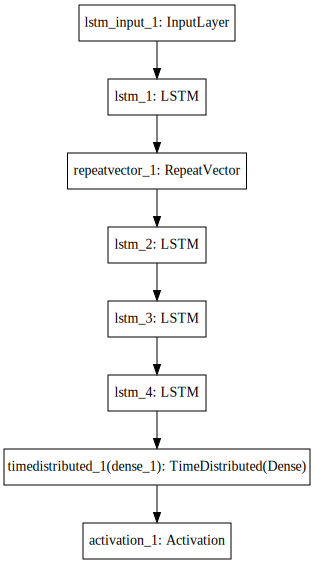

In [36]:
import pydotplus
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))